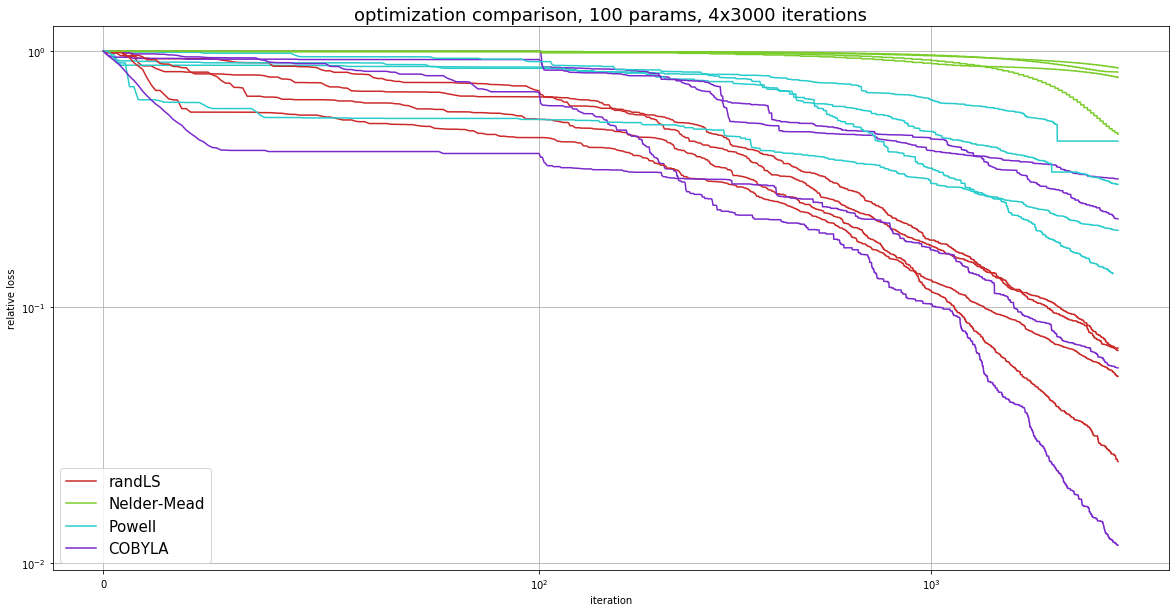

,Method,Avg Loss,iters/sec
0,randLS,0.0539,8.7k
1,Nelder-Mead,0.738,14.3k
2,Powell,0.27,42.7k
3,COBYLA,0.152,1.3k


In [29]:
import time
import numpy as np
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
%matplotlib inline

nX = 100
lossList = np.zeros(175000)
lossCount = 0
def loss(x):
    d = np.dot(A,x-xOpt)
    L = np.sum((np.abs(d)**2+.1)**.5-.1**.5)
    #L = (1 + np.sum(d**2))**.5
    #L = np.sum(np.abs(d))
    global lossList, lossCount
    lossList[lossCount] = L
    lossCount += 1
    return L;

def norm(x):
    return np.sqrt(np.sum(x**2))

def randLS_search(lossfun, x1, nIter):
    nV, xStep, minStep, maxStep = 16, 0.05*nX**.5, .01*nX**.5, .3*nX**.5
    X = np.zeros([nV,nX])
    lx = np.zeros(nV)
    xDir = 0*x1 + (np.random.rand(nX)-.5)*(12/nX)**.5
    xMin, lMin = 1.0*x1, 1e10

    for iter in range(nIter):
        if iter>3:
            N=min(iter,nV)
            lMin = np.min(lx[:N])
            minInd, maxInd = np.argmin(lx[:N]), np.argmax(lx[:N])
            xMin = X[minInd,:]
            nR = N-2
            R = (np.random.rand(nR,nX)-.5)*((12/nX)**.5) # ~zero mean, unit norm
            R[0,:] = xDir
            xDr = np.dot(X[:N,:]-xMin, R.T)
            lsTrg = lx[:N]-lMin
            gr = np.linalg.solve(np.dot(xDr.T,xDr)*(1+.1*np.eye(nR))+1e-5, np.dot(xDr.T, lsTrg))
            xDir = np.dot(gr,R)
            xDir *= (1/norm(xDir))
            newX = xMin - xDir * xStep
        else:
            newX = xMin + .05 * np.random.randn(nX)
    
        newLoss = loss(newX)
        xStep = np.maximum(minStep, np.minimum(maxStep, xStep * .707*(1+float(newLoss<lMin))))
        wInd = iter if (iter<nV) else maxInd
        X[wInd,:] = newX
        lx[wInd] = newLoss
    return xMin, lMin

##### all scipy.optimize gradient-free methods for comparison ############
nIter, nReps = 3000, 4
ax=plt.figure(figsize=(20, 10));
methods = ['randLS', 'Nelder-Mead', 'Powell', 'COBYLA']
methStats = np.zeros([len(methods),3])

for rep in range(nReps):
    A = np.random.rand(nX,nX) - rep/nReps # reps have different correlation
    xOpt = np.random.randn(nX)
    x1 = np.random.randn(nX)
    for ind, meth in enumerate(methods):
        lossCount=0
        T0 = time.perf_counter()
        if meth=='randLS':
            res = randLS_search(loss, x1, nIter)
        else:
            # hack to get reasonable number of iterations from Powell
            maxIter = nIter/(10*nX) if meth=='Powell' else nIter 
            res = scipy.optimize.minimize(loss, x1, method=meth, options={'maxiter': maxIter, 'disp': False})
        nPlot = min(lossCount, nIter)
        minVec = np.minimum.accumulate(lossList[:nPlot]/lossList[0])
        methStats[ind,0] += lossCount
        methStats[ind,1] += (time.perf_counter()-T0)
        methStats[ind,2] += minVec[-1]

        line, = plt.plot(np.arange(nPlot), minVec, color=hsv_to_rgb([ind/len(methods),.8,.8]))
        if rep==0:
            line.set_label(meth)

plt.rcParams.update({'font.size': 15})
plt.xscale('symlog', linthreshx=100)
plt.yscale('symlog', linthreshy=.01)
plt.title("optimization comparison, %d params, %dx%d iterations" % (nX, nReps, nIter))
plt.xlabel('iteration')
plt.ylabel('relative loss')
plt.grid(True)
plt.legend()
plt.show()

tabData = []
for ind, meth in enumerate(methods):
    tabData.append([meth, "%.3g" % (methStats[ind,2]/nReps), "%.1fk" % (1e-3*methStats[ind,0]/methStats[ind,1]) ])

pd.DataFrame(tabData, columns=["Method", "Avg Loss", "iters/sec"])